# 3D DenseNet 121(V3)

In [74]:
import os
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import SequentialSampler, RandomSampler

from collections import defaultdict

import monai
from monai.losses import FocalLoss
from monai.data import CacheDataset, DataLoader
from monai.transforms import (EnsureChannelFirstd, Compose, Resized, RandGaussianNoised, ScaleIntensityRanged,RandRotated, RandAffined, LoadImaged)

In [75]:
# Check environment
print(torch.__version__)
print(torch.version.cuda)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

2.7.0+cu128
12.8
Using cuda device


In [8]:
def labels_to_numeric(labels_df):
    label_cols = [
        'fracture_classification',
        'gt_displacement_greater_equal_to_1cm',
        'shaft_translation',
        'varus_malalignment',
        'art_involvement'
    ]
    labels_df = labels_df.loc[:, ['patient_id'] + label_cols]

    encoders = {}
    for col in label_cols:
        le = LabelEncoder().fit(labels_df[col])
        labels_df[col] = le.transform(labels_df[col])
        encoders[col] = le
    return labels_df, encoders

In [9]:
def extract_patient_id(file_path):
    filename = os.path.basename(file_path)
    main_part = filename.split('.')[0]
    desired_part = main_part.split('-')[0]
    return desired_part.lower()

In [10]:
def sort_labels(images, df):

    label_map = {}
    for _, row in df.iterrows():
        pid = row["patient_id"].lower()
        label_map[pid] = {
            'fracture': row['fracture_classification'],
            'displacement': row['gt_displacement_greater_equal_to_1cm'],
            'shaft_trans': row['shaft_translation'],
            'varus': row['varus_malalignment'],
            'articular': row['art_involvement']
        }

    labels = []
    for path in images:
        pid = extract_patient_id(path)
        labels.append([
            label_map[pid]['fracture'],
            label_map[pid]['displacement'],
            label_map[pid]['shaft_trans'],
            label_map[pid]['varus'],
            label_map[pid]['articular']
        ])

    return np.array(labels)

In [11]:
train_labels_df = pd.read_csv('train_labels.csv')
test_labels_df = pd.read_csv('test_labels.csv')

train_labels_df, train_encoders = labels_to_numeric(train_labels_df)
test_labels_df, test_encoders = labels_to_numeric(test_labels_df)
# print(train_encoders)

train_images = sorted(glob.glob("new_datasets/one_side_train/*.nii"))
test_images = sorted(glob.glob("new_datasets/one_side_test/*.nii"))


train_labels = sort_labels(train_images, train_labels_df)  # (N,5)
test_labels = sort_labels(test_images, test_labels_df)
# print(train_labels[0])

In [7]:
# columns = ["fracture_classification", "gt_displacement_greater_equal_to_1cm",
#                    "shaft_translation", "varus_malalignment", "art_involvement"]
# new_df = pd.DataFrame(train_labels, columns=columns)
# import eda2
#
# eda2.visualize_label_distribution(
#     out_df=new_df,
#     label_columns=columns,
#     save_path='tools/add_multi_label_distribution.png'
# )

In [12]:
train_dicts = [{
    "image": img_path,
    "label": lbl
} for img_path, lbl in zip(train_images, train_labels)]

val_dicts = [{
    "image": img_path,
    "label": lbl
} for img_path, lbl in zip(test_images, test_labels)]

In [13]:
train_transforms = Compose([
    LoadImaged(keys=["image"], image_only=True),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityRanged(keys=["image"], a_min=-500, a_max=1300,b_min=0.0,b_max=1.0,clip=True),
    RandRotated(
    keys=["image"],
    range_x=6.0,  # X
    range_y=6.0,  # Y
    range_z=6.0,  # Z
    prob=0.5,
    padding_mode="border",
    mode="bilinear"
    ),
    Resized(keys=["image"], spatial_size=(128,128,128)),

])

val_transforms = Compose([
    LoadImaged(keys=["image"], image_only=True),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityRanged(keys=["image"], a_min=-500, a_max=1300,b_min=0.0,b_max=1.0,clip=True),

    Resized(keys=["image"], spatial_size=(128,128,128)),

])

In [14]:
train_ds = CacheDataset(
    data=train_dicts,
    transform=train_transforms,
    num_workers=4
)

val_ds = CacheDataset(
    data=val_dicts,
    transform=val_transforms,
    num_workers=4
)

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    sampler=RandomSampler(train_ds),
    num_workers=4,
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    sampler=SequentialSampler(val_ds),
    num_workers=4
)

Loading dataset: 100%|██████████| 117/117 [00:02<00:00, 55.86it/s]


In [16]:
class MultiTaskLoss(nn.Module):
    def __init__(self, weights, device="cuda"):
        super().__init__()
        self.weights = weights
        self.loss_fns = nn.ModuleList([

            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),


            FocalLoss(
                gamma=2.0,
                alpha=0.5,
                use_softmax=False,
            ).to(device),


            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),


            FocalLoss(
                gamma=2.0,
                alpha=0.5,
                use_softmax=False,
            ).to(device),


            FocalLoss(
                gamma=2.0,
                use_softmax=True,
                to_onehot_y=True,
                include_background=True
            ).to(device),
        ])

    def forward(self, outputs, targets):
        total_loss = 0
        losses = []

        for i, (fn, w) in enumerate(zip(self.loss_fns, self.weights)):
            out = outputs[i]
            tgt = targets[:, i]

            if i in [1,3]:
                out = out.unsqueeze(-1) if out.dim() == 1 else out
                tgt = tgt.float().unsqueeze(-1)
            else:
                tgt = tgt.long()

            loss = w * fn(out, tgt)
            losses.append(loss)
            total_loss += loss

        return total_loss, losses

In [13]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    task_losses = defaultdict(float)
    task_dict = {
        0:'fracture',
        1:'displacement',
        2:'shaft_trans',
        3:'varus',
        4:'articular',
    }

    preds = {task: [] for task in task_dict.values()}
    truths = {task: [] for task in task_dict.values()}

    for batch in loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss, losses = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for i,loss_val in enumerate(losses):
            task_losses[i] += loss_val.item()

        for i, task_name in task_dict.items():
            if i in [0, 2, 4]:
                pred = outputs[i].argmax(dim=1)
            else:
                out = outputs[i].squeeze(-1) if outputs[i].dim() > 1 else outputs[i]
                pred = (torch.sigmoid(out) > 0.5).long()

            preds[task_name].append(pred.detach().cpu().numpy())
            truths[task_name].append(labels[:, i].cpu().numpy())

    for task in preds:
        preds[task] = np.concatenate(preds[task])
        truths[task] = np.concatenate(truths[task])

    metrics = {}
    for task in task_dict.values():
        metrics[f'{task}_acc'] = accuracy_score(truths[task], preds[task])

    avg_loss = total_loss / len(loader)
    task_avg = {k: v/len(loader) for k, v in task_losses.items()}

    return avg_loss, task_avg, metrics

In [17]:
def calc_metrics(outputs, labels, is_multiclass):
    metrics = {}

    if is_multiclass:
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        classes = np.arange(probs.shape[1])
        metrics['accuracy'] = accuracy_score(labels, preds)

        auc_scores = []
        label_bin = label_binarize(labels, classes=np.arange(probs.shape[1]))
        for i in range(probs.shape[1]):
            auc = roc_auc_score(
                label_bin[:,i],
                probs[:,i].numpy(),
                multi_class='ovr')
            auc_scores.append(auc)
        metrics['auc'] = {j: auc_scores[j] for j in range(len(auc_scores))}

        cm = confusion_matrix(labels, preds)
        n_classes = cm.shape[0]
        sensitivity_list = []
        specificity_list = []
        ppv_list = []
        npv_list = []

        for i in range(n_classes):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            fp = np.sum(cm[:, i]) - tp
            tn = np.sum(cm) - tp - fn - fp

            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

            ppv_list.append(ppv)
            npv_list.append(npv)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)


        metrics['ppv'] = {j: ppv_list[j] for j in range(len(ppv_list))}
        metrics['npv'] = {j: npv_list[j] for j in range(len(npv_list))}
        metrics['sensitivity'] = {j: sensitivity_list[j] for j in range(len(sensitivity_list))}
        metrics['specificity'] = {j: specificity_list[j] for j in range(len(specificity_list))}

    else:
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        metrics['accuracy'] = accuracy_score(labels, preds)

        prob_class1 = probs.numpy()
        prob_class0 = 1 - prob_class1
        auc_scores = []

        auc0 = roc_auc_score(labels.numpy(), prob_class0)
        auc1 = roc_auc_score(labels.numpy(), prob_class1)
        auc_scores.append(auc0)
        auc_scores.append(auc1)
        metrics['auc'] = {j: auc_scores[j] for j in range(len(auc_scores))}

        cm = confusion_matrix(labels, preds)
        sensitivity_list = []
        specificity_list = []
        ppv_list = []
        npv_list = []

        for i in range(2):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            fp = np.sum(cm[:, i]) - tp
            tn = np.sum(cm) - tp - fn - fp

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

            ppv_list.append(ppv)
            npv_list.append(npv)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)

        metrics['ppv'] = {j: ppv_list[j] for j in range(len(ppv_list))}
        metrics['npv'] = {j: npv_list[j] for j in range(len(npv_list))}
        metrics['sensitivity'] = {j: sensitivity_list[j] for j in range(len(sensitivity_list))}
        metrics['specificity'] = {j: specificity_list[j] for j in range(len(specificity_list))}

    return cm, metrics

In [18]:
def validate(model, val_loader, loss_function):
    model.eval()
    total_loss = 0.0
    task_losses = defaultdict(float)
    task_dict = {
        0:'fracture',
        1:'displacement',
        2:'shaft_trans',
        3:'varus',
        4:'articular',
    }

    all_outputs = {task: [] for task in task_dict.values()}
    all_labels = {task: [] for task in task_dict.values()}

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device).long()

            outputs = model(inputs)
            loss, losses = loss_function(outputs, labels)

            total_loss += loss.item()

            for i, task_name in task_dict.items():
                all_outputs[task_name].append(outputs[i].detach().cpu())
                all_labels[task_name].append(labels[:, i].cpu())

    avg_loss = total_loss / len(val_loader)
    detailed_metrics = {}

    cms = []
    for task_name in task_dict.values():
        outputs_tensor = torch.cat(all_outputs[task_name])
        labels_tensor = torch.cat(all_labels[task_name])

        is_multiclass = task_name in ['fracture', 'shaft_trans', 'articular']

        cm, task_metrics = calc_metrics(outputs_tensor, labels_tensor, is_multiclass)
        cms.append(cm)

        task_metrics['loss'] = task_losses[task_name] / len(val_loader)

        detailed_metrics[task_name] = task_metrics

    return cms, avg_loss, detailed_metrics


In [19]:
task_names = ['fracture', 'displacement', 'shaft_trans', 'varus', 'articular']
train_losses = []
val_losses = []
train_metrics_history = {task: {'loss': [], 'acc': []} for task in task_names}
val_metrics_history = {task: {'loss': [], 'acc': [], 'auc': []} for task in task_names}
task_name_dict = {
    'fracture':0,
    'displacement':1,
    'shaft_trans':2,
    'varus':3,
    'articular':4,
}

In [17]:
model = monai.networks.nets.DenseNet121(
    growth_rate=32,
    spatial_dims=3,
    in_channels=1,
    out_channels=1024
).to(device)

In [18]:
from torch.optim.lr_scheduler import LinearLR,CosineAnnealingLR
criterion = MultiTaskLoss(weights=[1.0, 1.0, 1.0, 1.0, 1.0])
# optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=10,
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=90,
    eta_min=1e-5
)

In [19]:
start_time = time.time()
best_val_loss = float('inf')

for epoch in range(100):

    train_loss, task_loss, train_metrics = train_epoch(
        model, train_loader, criterion, optimizer
    )
    if epoch<10:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    train_losses.append(train_loss)
    for task in task_names:
        train_metrics_history[task]['loss'].append(task_loss[task_name_dict[task]])
        train_metrics_history[task]['acc'].append(train_metrics[f'{task}_acc'])


    if (epoch+1) % 5 == 0:
        _, val_loss, val_metrics = validate(model, val_loader, criterion)
        val_losses.append(val_loss)


        for task in task_names:
            val_metrics_history[task]['loss'].append(val_metrics[task]['loss'])
            val_metrics_history[task]['acc'].append(val_metrics[task]['accuracy'])
            if task in ['displacement', 'varus']:
                val_metrics_history[task]['auc'].append(val_metrics[task]['auc'])


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "best_multi_3d_clf4.pth")

        print(f"\nEpoch {epoch+1}/100:")
        print(f"lr: {optimizer.param_groups[0]['lr']}")
        print(f"[Train] Loss: {train_loss:.4f}")
        print(f"Fracture acc: {val_metrics['fracture']['accuracy']:.3f}")


torch.save(model.state_dict(), "final_multi_3d_clf5.pth")
print(f"Training time: {(time.time()-start_time)//60} minutes")


Epoch 5/100:
lr: 0.000275
[Train] Loss: 0.4514
Fracture acc: 0.487

Epoch 10/100:
lr: 0.0005000000000000001
[Train] Loss: 0.4308
Fracture acc: 0.427

Epoch 15/100:
lr: 0.0004962778994879912
[Train] Loss: 0.4091
Fracture acc: 0.607

Epoch 20/100:
lr: 0.00048522469209254774
[Train] Loss: 0.3701
Fracture acc: 0.581

Epoch 25/100:
lr: 0.0004671762239271877
[Train] Loss: 0.3596
Fracture acc: 0.607

Epoch 30/100:
lr: 0.0004426808885641498
[Train] Loss: 0.3453
Fracture acc: 0.709

Epoch 35/100:
lr: 0.0004124829643732024
[Train] Loss: 0.3306
Fracture acc: 0.675

Epoch 40/100:
lr: 0.00037750000000000023
[Train] Loss: 0.3143
Fracture acc: 0.667

Epoch 45/100:
lr: 0.00033879493511478905
[Train] Loss: 0.2749
Fracture acc: 0.684

Epoch 50/100:
lr: 0.0002975438035283981
[Train] Loss: 0.2818
Fracture acc: 0.684

Epoch 55/100:
lr: 0.00025500000000000007
[Train] Loss: 0.2674
Fracture acc: 0.658

Epoch 60/100:
lr: 0.0002124561964716021
[Train] Loss: 0.2354
Fracture acc: 0.701

Epoch 65/100:
lr: 0.00017

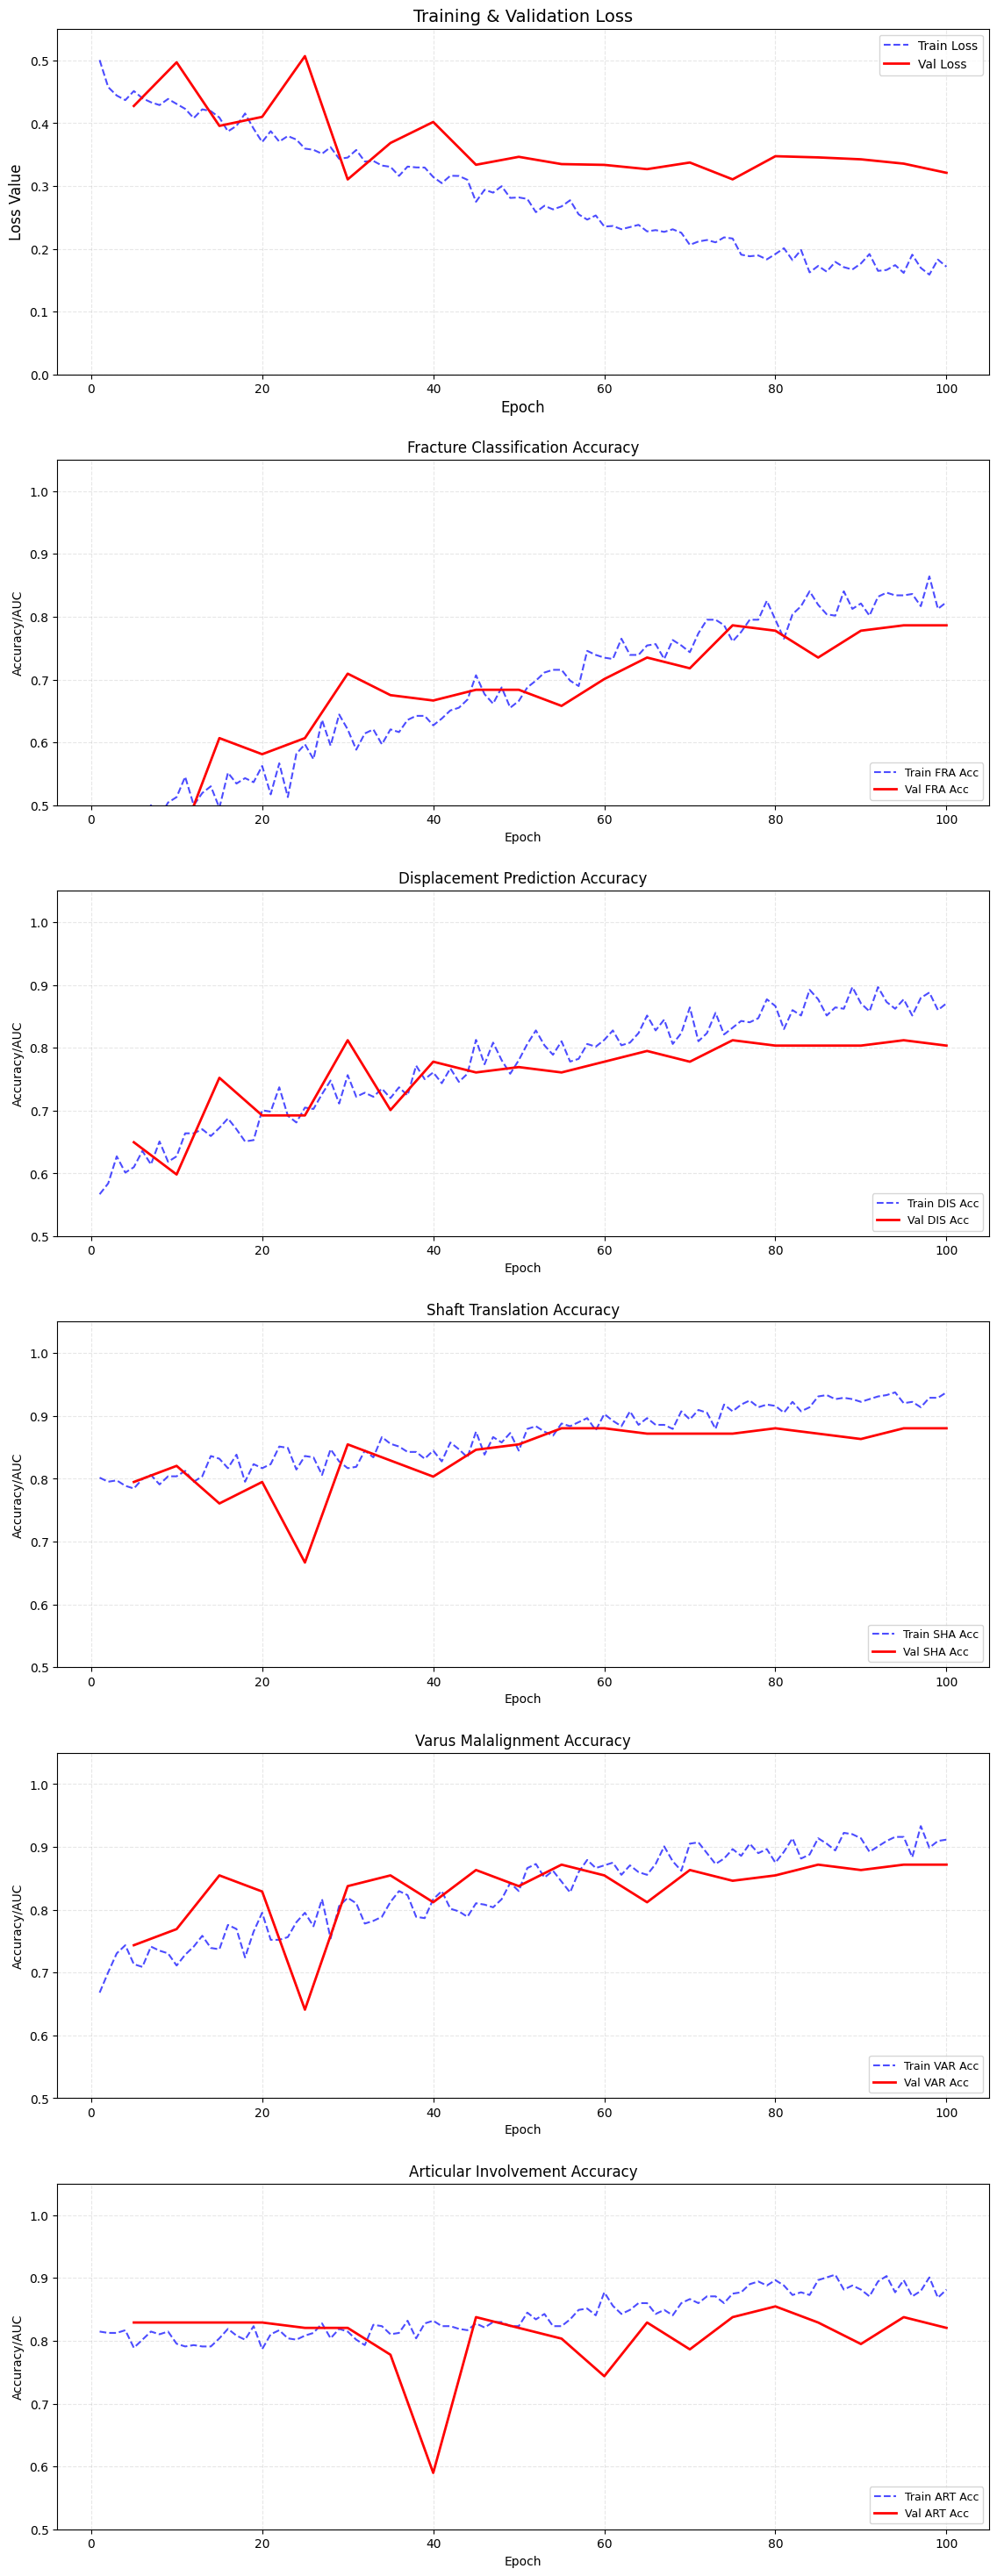

In [20]:
task_names = ['fracture', 'displacement', 'shaft_trans', 'varus', 'articular']
task_titles = [
    'Fracture Classification Accuracy',
    'Displacement Prediction Accuracy',
    'Shaft Translation Accuracy',
    'Varus Malalignment Accuracy',
    'Articular Involvement Accuracy'
]

plt.figure(figsize=(12, 30))

plt.subplot(6, 1, 1)

plt.plot(range(1, len(train_losses)+1), train_losses, 'b--', alpha=0.7, label='Train Loss')

val_x = np.arange(5, 5*len(val_losses)+1, 5)
plt.plot(val_x, val_losses, 'r-', linewidth=2, label='Val Loss')

plt.title('Training & Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.ylim(0, max(train_losses)*1.1)

for i, task in enumerate(task_names):
    plt.subplot(6, 1, i+2)


    train_acc = train_metrics_history[task]['acc']
    plt.plot(range(1, len(train_acc)+1), train_acc, 'b--', alpha=0.7, label=f'Train {task[:3].upper()} Acc')


    val_acc = val_metrics_history[task]['acc']
    val_x = np.arange(5, 5*len(val_acc)+1, 5)
    plt.plot(val_x, val_acc, 'r-', linewidth=2, label=f'Val {task[:3].upper()} Acc')


    plt.title(task_titles[i], fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy/AUC', fontsize=10)
    plt.ylim(0.5, 1.05)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='lower right', fontsize=9)

plt.tight_layout(pad=3.0, h_pad=2.0)
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


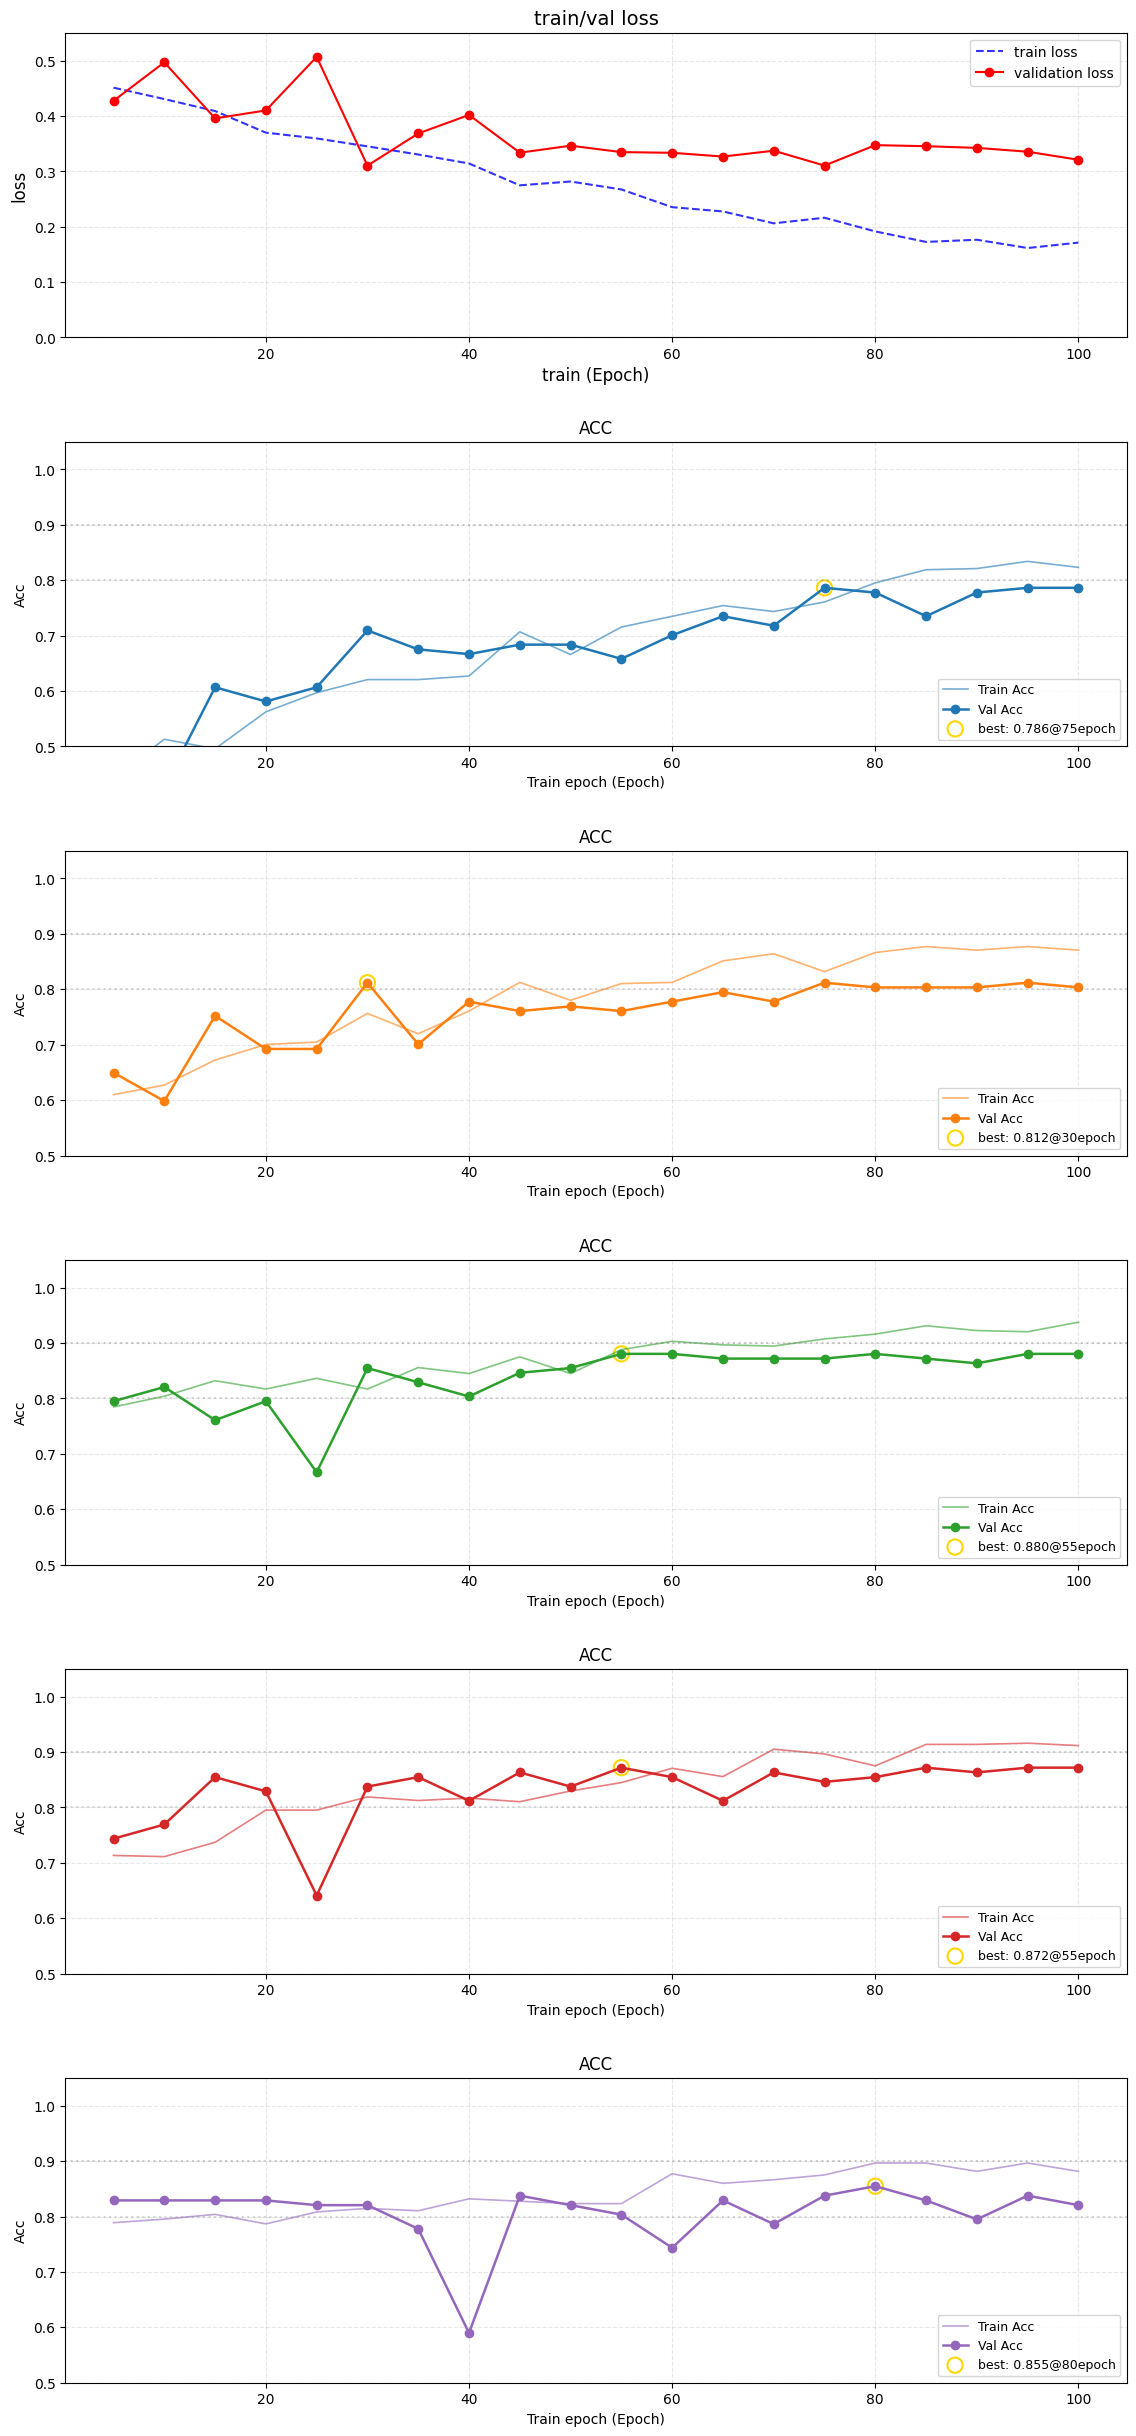

In [21]:
plt.rcParams.update({'font.size': 10, 'font.family': 'sans-serif'})


task_config = [
    {'name': 'fracture', 'title': 'ACC', 'color': '#1f77b4'},
    {'name': 'displacement', 'title': 'ACC', 'color': '#ff7f0e'},
    {'name': 'shaft_trans', 'title': 'ACC', 'color': '#2ca02c'},
    {'name': 'varus', 'title': 'ACC', 'color': '#d62728'},
    {'name': 'articular', 'title': 'ACC', 'color': '#9467bd'}
]

plt.figure(figsize=(12, 25))


plt.subplot(6, 1, 1)
train_x = [5*(i+1) for i in range(len(train_losses[4::5]))]
plt.plot(train_x, train_losses[4::5], 'b--', alpha=0.8, linewidth=1.5, label='train loss')


val_x = [5*(i+1) for i in range(len(val_losses))]
plt.plot(val_x, val_losses, 'ro-', markersize=6, linewidth=1.5, label='validation loss')

plt.title('train/val loss', fontsize=14)
plt.xlabel('train (Epoch)', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.ylim(0, max(train_losses)*1.1)


for i, task in enumerate(task_config):
    ax = plt.subplot(6, 1, i+2)
    color = task['color']


    train_acc = train_metrics_history[task['name']]['acc'][4::5]
    plt.plot(train_x, train_acc, color=color, linestyle='-',
             alpha=0.6, linewidth=1.2, label=f"Train Acc")


    val_acc = val_metrics_history[task['name']]['acc']
    plt.plot(val_x, val_acc, color=color, marker='o',
             markersize=6, linewidth=1.8, label=f"Val Acc")


    best_idx = np.argmax(val_acc)
    best_epoch = val_x[best_idx]
    best_acc = val_acc[best_idx]
    plt.scatter(best_epoch, best_acc, s=120, facecolors='none',
                edgecolors='gold', linewidths=1.5,
                label=f'best: {best_acc:.3f}@{best_epoch}epoch')

    plt.title(task['title'], fontsize=12)
    plt.xlabel('Train epoch (Epoch)', fontsize=10)
    plt.ylabel('Acc', fontsize=10)
    plt.ylim(0.5, 1.05)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='lower right', fontsize=9)

    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.4)
    ax.axhline(y=0.8, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout(pad=3.0, h_pad=2.5)
plt.savefig('training_metrics_acc_only.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
name_dict = {
    'fracture':'fracture_classification',
    'displacement':'gt_displacement_greater_equal_to_1cm',
    'shaft_trans':'shaft_translation',
    'varus':'varus_malalignment',
    'articular':'art_involvement',
}

### Internal validation

In [23]:
cms, val_loss, detailed_metrics = validate(model, val_loader, criterion)
for task, metrics in detailed_metrics.items():
    print(f"\nTask: {task}")
    print(f"\tOverall Acc: {metrics['accuracy']:.3f}")
    for key in metrics['auc'].keys():
        print(f"\t{train_encoders[name_dict[task]].classes_[key]}\tAUC: {metrics['auc'][key]:.3f} | Sen: {metrics['sensitivity'][key]:.3f} | Spec: {metrics['specificity'][key]:.3f}")


Task: fracture
	Overall Acc: 0.786
	1-part	AUC: 0.929 | Sen: 0.643 | Spec: 0.971
	2-part	AUC: 0.874 | Sen: 0.795 | Spec: 0.836
	dislocation	AUC: 0.990 | Sen: 0.846 | Spec: 0.981
	multipart	AUC: 0.933 | Sen: 0.804 | Spec: 0.887

Task: displacement
	Overall Acc: 0.803
	no	AUC: 0.124 | Sen: 0.870 | Spec: 0.761
	yes	AUC: 0.876 | Sen: 0.761 | Spec: 0.870

Task: shaft_trans
	Overall Acc: 0.880
	entire	AUC: 0.938 | Sen: 0.471 | Spec: 1.000
	none	AUC: 0.951 | Sen: 1.000 | Spec: 0.391
	substantial	AUC: 0.707 | Sen: 0.167 | Spec: 1.000

Task: varus
	Overall Acc: 0.872
	no	AUC: 0.088 | Sen: 0.927 | Spec: 0.743
	yes	AUC: 0.912 | Sen: 0.743 | Spec: 0.927

Task: articular
	Overall Acc: 0.821
	headsplit	AUC: 0.551 | Sen: 0.000 | Spec: 0.982
	none_or_rim	AUC: 0.742 | Sen: 0.918 | Spec: 0.350
	subcritical	AUC: 0.816 | Sen: 0.438 | Spec: 0.941


In [21]:
task_meta = {
    'fracture': {
        'type': 'multiclass',
        'labels': train_encoders['fracture_classification'].classes_
    },
    'displacement': {
        'type': 'binary',
        'labels': train_encoders['gt_displacement_greater_equal_to_1cm'].classes_
    },
    'shaft_trans': {
        'type': 'multiclass',
        'labels': train_encoders['shaft_translation'].classes_
    },
    'varus': {
        'type': 'binary',
        'labels': train_encoders['varus_malalignment'].classes_
    },
    'articular': {
        'type': 'multiclass',
        'labels': train_encoders['art_involvement'].classes_
    }
}

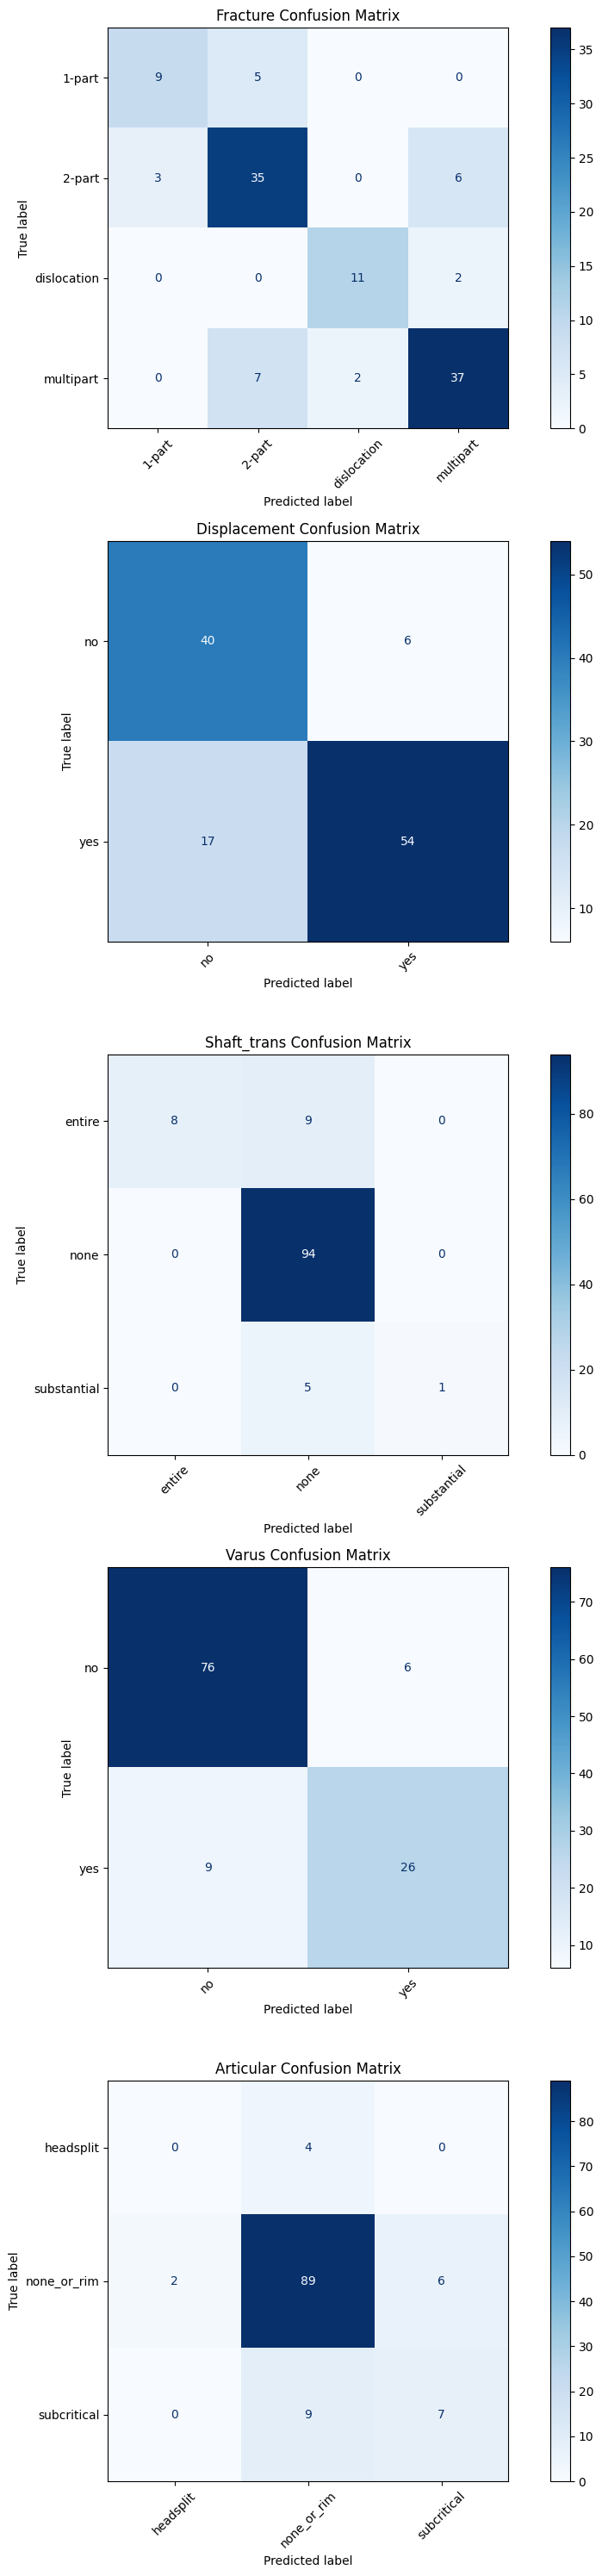

In [25]:
plt.figure(figsize=(10, 30))
for i, (task, meta) in enumerate(task_meta.items(), 1):
    plt.subplot(5, 1, i)

    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i-1],
                                 display_labels=meta['labels'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'{task.capitalize()} Confusion Matrix')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()